In [1]:
import numpy as np
from scipy.stats import binom, gamma, beta, expon, poisson, uniform, bernoulli
import scipy.stats as stats
from joblib import Parallel, delayed
from scipy.special import gamma as gammaFunc
import random

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import tqdm

import pickle 

import math

import itertools

import sys
sys.path.insert(0, './../Scripts/')
from Plot import *

# Bayesian SIR Model with Change Points

The **stochastic susceptible-infected-removed (SIR)** model with change points is proposed to accommodate the situations where the transmission rate and the removal rate may vary significantly at change points. Bayesian inference based on a Markov chain Monte Carlo algorithm is developed to estimate both the locations of change points as well as the transmission rate and removal rate within each stage. Experiments on simulated data reveal the effectiveness of the proposed method.

## SIR Model

### Standard SIR Model
The susceptible-infected-removed (SIR) model is the most widely used mathematical tool to model the spreading of infectious diseases. Given a closed population of N individuals and three possible states, susceptible (S),
infectious (I) and removed (R, either recovered or dead), each individual is assumed to be in one state at any time. As time goes by, the state of each individual would evolve from S to I and then from I to R, implying the process that an individual gets infected and then recovers or dies. 

Let S(t), I(t) and R(t) denote the number of susceptible, infectious and removed individuals in the population at time point t ( t ≥ 0 ) respectively. Define P(t) = I(t)/N as the proportion of infectious individuals at time t. Assuming that in-person contacts among individuals follow the Erdős–Rényi model, the standard SIR model describes the flow of individuals from S to I and then from I to R by a set of ordinary differential equations without the access to individual records of infection and removal,

$$
\begin{cases}
\frac{dS(t)}{dt} = -\beta S(t) P(t),\\ 
\frac{dI(t)}{dt} = \beta S(t) P(t) - \gamma I(t), \\ 
\frac{dR(t)}{dt} = \gamma I(t),\\ 
\end{cases}
\tag{1}
$$

where $\beta$ and $\gamma$ are the transmission rate parameter and the removal rate parameter respectively.

### Stochastic SIR Model With Change Points
The stochastic SIR model with change points has been introduced to describe the spreading of infectious diseases with time-varying parameters. The change points exist because there could be some societal changes, such as the implementation of new social distancing policies, restrictions on individual activities, and the increase of medical resources on patients, which would cause sudden changes in either the transmission rate or the removal rate or both.

We assume that the study period is ${1,...,T}$ , where $T$ is the length of the study period. Let $\Delta I = (\Delta I_1,...,\Delta I_T)^T$ and $\Delta R = (\Delta R_1,...,\Delta R_T)^T$ be sequences of daily reported numbers of newly infected cases and removed cases respectively. Given the initial state of population ($S_0,I_0,R_0$), we define the discrete-time stochastic SIR model with change points as follows. For $t = 1,...,T$

$$
\begin{cases}
\Delta I_t \sim \text{Binomial}(S_{t-1},1-\exp(-\beta_tP_{t-1})), \\ 
    \Delta R_t \sim \text{Binomial}(I_{t-1},\gamma_t),\\ 
S_t = S_{t-1} - \Delta I_t,\\ 
I_t = I_{t-1} + \Delta I_t - \Delta R_t,\\ 
R_t = R_{t-1} + \Delta R_t,\\ 
\end{cases}
\tag{2}
$$

where $P_t = I_t /N$ is the proportion of infectious individuals at day t and ($S_t , I_t , R_t $) are updated at each timestep. Time-varying parameters $\beta_t \in (0, \infty)$ and $\gamma_t \in (0,1)$ represent the transmission rate and the removal rate at day t respectively.

To depict such dynamic patterns of pandemic evolvement, we introduce a latent binary vector $\mathbf{\delta} = (\delta_1,...,\delta_T)^T$, where $\delta_t = 1$ indicates that day $t$ is a change point and $\delta_t = 0$ otherwise. The index of the stage that contains day t is $\eta_t = \sum _{u=1}^t \delta _u$ and ghe stage index vector is $\mathbf{\eta} = (\eta_1,...,\eta_T)^T$. Thus, the study period is partioned into $K = \sum_{t=1}^T\delta_t$ stages. Within each stage, parameters $(\beta_t,\gamma_t)$ are assumed to be homogeneous.

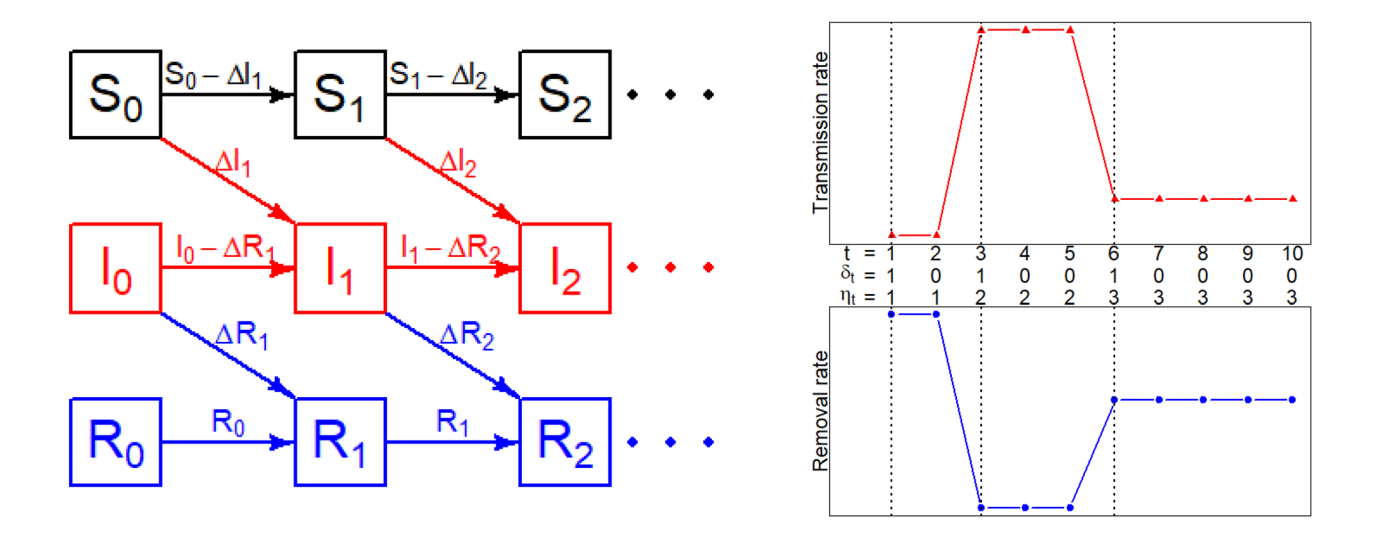

## Methodology

### Bayesian Inference with MCMC

To make Bayesian inference on parameters $\mathbf{\delta},\mathbf{b},\mathbf{r},\mathbf{\beta},\mathbf{\gamma}$, we used an MCMC algorithm to draw samples from the posterior distribution,

$$
\pi(\mathbf{\delta},\mathbf{b},\mathbf{r},\mathbf{\beta},\mathbf{\gamma}|S_0,I_0,R_0,\Delta I, \Delta R) \propto \pi(\mathbf{\delta})\prod^K_{k=1} \pi(b_k) \pi(r_k) \prod^T_{t=1} \{\pi(\beta_t|\mathbf{\delta},\mathbf{b})\mathbb{P}(\Delta I_t|S_{t-1},I_{t-1},\beta_t)\}\{\pi(\gamma_t|\mathbf{\delta},\mathbf{b})\mathbb{P}(\Delta R_t|I_{t-1},\gamma_t)\}
\tag{4}
$$


where $\pi(\cdot)$ and $\mathbb{P}(\cdot)$ represent the prior and likelihood functions, respectively.

Regarding the choice of likelihoods, we used those described in (2), while the priors are defined below

$$
\begin{cases}
\beta_t | \mathbf{\delta},b \sim \text{Exp}(b_{\eta_t})\\
\gamma_t | \mathbf{\delta},r \sim \text{Beta}(r_{\eta_t},1)\\
b_1,...,b_K \sim \text{Gamma}(0.1,0.1)\\
r_1,...,r_K \sim \text{Gamma}(0.1,0.1)\\
\delta_1,...,\delta_T \sim \text{Bernoulli(p)}\\
\end{cases}
\tag{3}
$$

with $\frac{1}{b_k}$ and $\frac{r_k}{1+r_k}$ the expected transmission rate and the expected removal rate in stage $k=1,...,K$, respectively.


To efficiently handle multi-parameter distributions, we employ Gibbs sampling, enabling us to operate within a multidimensional framework with a high acceptance rate. Actually, the proposed sampling strategy integrates a pure Metropolis-Hastings approach when sampling delta, while other parameters are sampled from distributions conditioned on the remaining updated parameters.

#### $\delta$ sampling
Given current values $\mathbf{\delta}^{(g)}$, $\mathbf{\beta}^{(g)}$, $\mathbf{\gamma}^{(g)}$, $\delta$ sampling is based on a two steps algorithm:

<u>Generate a candidate $\delta^*$</u>
<br>
Initializing $\delta^* = \delta^{(g)}$, it is possible to generate a candidate with an add-delete-swap algorithm. This method is based on the selection of an operation {add, delete, swap} with probabilities,

$$
(p_{add},p_{delete},p_{swap})=
\begin{cases}
(1,0,0) &\quad \text{if $K^{(g)}=1$}\\ 
(0,1,0) &\quad \text{if $K^{(g)}=T$}\\ 
(1/3,1/3,1/3) &\quad \text{otherwise}\\ 
\end{cases}
\tag{5}
$$

<u>Update $\delta^{(g)}$</u>
<br>
Given the candidate $\delta^{(g)}$, we compute the Metropolis-Hasting ratio as

$$
m_{MH} = \frac{J(\delta^{(g)}|\delta^*)}{J(\delta^*|\delta^{(g)})}\cdot\frac{\pi(\beta^{(g)},\gamma^{(g)}|\delta^*)}{\pi(\beta^{(g)},\gamma^{(g)}|\delta^{(g)})}\cdot\frac{\pi(\delta^*)}{\pi(\delta^{(g)})}
\tag{6}
$$ 
with
    
$$
\frac{\pi(\delta^*)}{\pi(\delta^{(g)})} = \Big(\frac{p}{1-p}\Big)^{\sum^T_{t=1}(\delta^*_t-\delta^{(g)}_t)}
$$
<br>
<br>
$$
\pi(\beta^{(g)},\gamma^{(g)}|\delta) \propto \prod^K_{k=1}\Big\{ \frac{\Gamma(\rho _k)}{\big(0.1+\sum^T_{t=1} \beta_t^{(g)}\mathbb{I}(\eta_t = k)\big)^{\rho _k}} \Big\}\Big\{ \frac{\Gamma(\rho _k)}{\big(0.1+\sum^T_{t=1}-\log \gamma_t^{(g)}\mathbb{I}(\eta_t = k)\big)^{\rho _k}} \Big\} \;\;\;\;,\;\;\rho _k = 0.1+\sum^T_{t=1}\mathbb{I}(\eta_t = k)
\tag{7}$$
<br>
<br>
$$
\frac{J(\delta^{(g)}|\delta^*)}{J(\delta^*|\delta^{(g)})}=
\begin{cases}
1 &\quad \text{if swap}\\ 
3/(T-1) &\quad \text{if delete and $K^{(g)} = 2$ or $K^{(g)} = (T-1)$}\\
(K^{(g)}-1)/(T-K^*) &\quad \text{if delete and $K^{(g)} \not= 2,(T-1)$}\\ 
(T-1)/3 &\quad \text{if add and $K^{(g)} = 1$ or $K^{(g)} = (T)$}\\ 
(T-K^{(g)})/(K^*-1) &\quad \text{if add and $K^{(g)} \not= 1,T$}\\ 
\end{cases}
\tag{8}
$$
    
Then we obtain the updated value $\delta^{(g+1)}$ as
$$
\delta^{(g+1)}=
\begin{cases}
\delta^* &\quad \text{with probability min(1 , $m_{MH}$)}\\ 
\delta^{(g)} &\quad \text{with probability 1-min(1 , $m_{MH}$)}\\ 
\end{cases}
\tag{9}
$$

In [2]:
def propose_delta(Delta_hat, K_hat, T_max=100, verbose=False):

    ########## change type
    ## add–delete–swap - proposal step
    # -1 delete
    # 0 swap
    # +1 add
    if K_hat==1:
        change_type = 1
        
    elif K_hat==T_max:
        change_type = -1

    else:
        change_type = np.random.choice([-1, 0, 1])
            
    Delta_hat_candidate = Delta_hat.copy()
    
    ########## proposal phase
    if change_type != 0:
        if change_type == 1:
            possible_change_indices = np.where(Delta_hat[1:] == 0)[0]+1
        if change_type == -1:
            possible_change_indices = np.where(Delta_hat[1:] == 1)[0]+1
            
        index_to_change = np.random.choice(possible_change_indices)
            
        Delta_hat_candidate[index_to_change] = 1-Delta_hat_candidate[index_to_change]
            
    else:
        possible_change_indices = np.where(np.abs(Delta_hat[1:-1] - Delta_hat[2:]) == 1)[0]+1
        index_to_change = np.random.choice(possible_change_indices)

        Delta_hat_candidate[index_to_change + np.array([0, 1])] = Delta_hat_candidate[index_to_change + np.array([1, 0])]

    Stage_hat_candidate = np.cumsum(Delta_hat_candidate, dtype=int)-1
    K_hat_candidate = np.sum(Delta_hat_candidate, dtype=int)
    
    if verbose:
        print("Change:", change_type)
        print("Original:",  np.where(Delta_hat==1)[0])
        print("Candidate:", np.where(Delta_hat_candidate==1)[0])
        print("---------------------------")

    return Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate


def sample_delta_1(Delta_hat, Stage_hat, K_hat, beta_hat, gamma_hat, 
                   p=0.01, b_shape=0.1, b_rate=0.1, r_shape=0.1, r_rate=0.1, T_max=100, verbose=False):
    
    # propose new delta
    Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate = propose_delta(Delta_hat, K_hat, T_max, verbose)


    ########## Metropolis-Hastings Phase
    # Prior log-ratio: pi(d*)/pi(d(g))
    log_pi = (K_hat_candidate-K_hat)*np.log(p/(1-p))
        
    # Likelihood log-ratio: pi(beta(g), gamma(g)|d*)/pi(beta(g), gamma(g)|d(g))
    log1_candidate = 0
    log2_candidate = 0
        
    for k in range(K_hat_candidate):
        ind_k = np.where(Stage_hat_candidate == k)[0]
        log1_candidate += np.log(gammaFunc(b_shape+len(ind_k))) - (b_shape+len(ind_k))*np.log(b_rate+np.sum(beta_hat[ind_k]))
        log2_candidate += np.log(gammaFunc(r_shape+len(ind_k))) - (r_shape+len(ind_k))*np.log(r_rate+np.sum(-np.log(gamma_hat[ind_k])))
        
    log1_original = 0
    log2_original = 0
                                     
    for k in range(K_hat):
        ind_k = np.where(Stage_hat == k)[0]
        log1_original += np.log(gammaFunc(b_shape+len(ind_k))) - (b_shape+len(ind_k))*np.log(b_rate+np.sum(beta_hat[ind_k]))
        log2_original += np.log(gammaFunc(r_shape+len(ind_k))) - (r_shape+len(ind_k))*np.log(r_rate+np.sum(-np.log(gamma_hat[ind_k])))
        
    log_L = (log1_candidate+log2_candidate) - (log1_original+log2_original)     
    
    # Jump probability log-ratio: J(d(g)|d*)/J(d*|d(g))
    JJ = 0
    if K_hat == K_hat_candidate:
        JJ = 1 
    elif ([K_hat_candidate, K_hat] == [1, 2] or [K_hat_candidate, K_hat] == [T_max, T_max-1]):
        JJ = 3/(T_max-1)
    elif ([K_hat_candidate, K_hat] == [2, 1] or [K_hat_candidate, K_hat] == [T_max-1, T_max]):
        JJ = (T_max-1)/3
    elif (K_hat_candidate-K_hat) == -1 and K_hat_candidate != 1 and K_hat_candidate != (T_max-1):
        JJ = (K_hat-1)/(T_max - K_hat_candidate)
    elif K_hat_candidate - K_hat == 1 and K_hat_candidate != 2 and K_hat_candidate != T_max:
        JJ = (T_max-K_hat)/(K_hat_candidate-1)
    log_JJ = np.log(JJ)

    
    # Metropolis-Hastings Ratio
    log_mMH = log_L+log_pi+log_JJ
    ratio = np.exp(min(0, log_mMH))

    if verbose:
        print("pi:", log_pi, np.exp(log_pi))
        print("likelihood:", log_L, np.exp(log_L))
        print("JJ:", log_JJ, JJ)
        print("m_MH:", log_mMH, np.exp(log_mMH))
    
    cxx = np.random.binomial(1, ratio) 
    if cxx == 1:
        Delta_hat = Delta_hat_candidate
        Stage_hat = Stage_hat_candidate
        K_hat     = K_hat_candidate
        
    return Delta_hat, Stage_hat, K_hat

#### b and r sampling
Given current values $\mathbf{\delta}^{(g+1)}$, $\mathbf{\beta}^{(g)}$, $\mathbf{\gamma}^{(g)}$, we sample $b_k^{(g+1)}$ and $r_k^{(g+1)}$ from their conditional posterior distributions

$$
\begin{cases}
\pi(b_k | \mathbf{\delta}^{(g+1)}, \mathbf{\beta}^{(g)}) = \text{Gamma}\Big(0.1+\sum^T_{t=1}\mathbb{I}(\eta_t^{(g+1)} = k),0.1+\sum^T_{t=1}\beta_t^{(g)}\mathbb{I}(\eta_t^{(g+1)} = k)\Big)\\
\pi(r_k | \mathbf{\delta}^{(g+1)}, \mathbf{\gamma}^{(g)}) = \text{Gamma}\Big(0.1+\sum^T_{t=1}\mathbb{I}(\eta_t^{(g+1)} = k),0.1+\sum^T_{t=1}-\log\gamma_t^{(g)}\mathbb{I}(\eta_t^{(g+1)} = k)\Big)\\
\end{cases}
\tag{10}
$$
for $k=1,...,K^{(g+1)}$, where $\mathbb{I}(\cdot)$ is the indicator function.

<br><br><br>


```python
b_hat = np.zeros(K_hat)
r_hat = np.zeros(K_hat)

for i in range(K_hat):
    L_i = np.where(Stage_hat == i)[0]
    
    b_hat[i] = gamma.rvs(size=1, a=(b_shape + len(L_i)), 
                            scale=1/(b_rate + np.sum(beta_hat[L_i])))
    
    r_hat[i] = gamma.rvs(size=1, a=(r_shape + len(L_i)), 
                            scale=1/(r_rate + np.sum(-np.log(gamma_hat[L_i]))))
    
```

#### $\beta$ and $\gamma$ sampling
As for the previous parameters, $\beta$ and $\gamma$ samples are obtained from their conditional posterior distributions. This method, though, is rather difficult for $\beta$ due to the complex expression of its posterior. Therefore we exploit a reparametrization trick introducing the auxiliary variable $\chi$ with components $\chi_t = 1 - e^{-\beta_tP_{t-1}}$. Given an exponential prior for $\beta$, it can be demonstrated that $\chi$ prior is a beta distribution

$$
\chi_t \sim \text{Beta}\Big(1,\frac{b_{\eta_t}}{P_{t-1}}\Big)
$$

Thus, given the current values $\mathbf{\delta}^{(g+1)}$, $\mathbf{b}^{(g+1)}$, $\mathbf{r}^{(g+1)}$, we sample $\chi_t^{(g+1)}$ and $\gamma_t^{(g+1)}$ from their conditional posterior distributions.

$$
\begin{cases}
\pi(\chi_t | S_{t-1},\Delta I_ t, b^{(g+1)}_{\eta_t^{(g+1)}}) = \text{Beta}\Big( 1 + \Delta I_t\;\;, \;\;b^{(g+1)}_{\eta_t^{(g+1)}}\frac{1}{P_{t-1}} + S_{t-1} - \Delta I_ t\Big)\\
\pi(\gamma_t | I_{t-1},\Delta R_ t, r^{(g+1)}_{\eta_t^{(g+1)}}) = \text{Beta}\Big( r^{(g+1)}_{\eta^{(g+1)}_t} + \Delta R_t\;\;,\;\; 1+ I_{t-1}-\Delta R_t\Big)\\
\end{cases}
\tag{12}
$$
for $t=1,...,T$.

Finally, $\beta$ samples are obtained from $\chi$ as follows:

$$
\beta_t = -\frac{\log(1-\chi_t)}{P_{t-1}}
\tag{11}
$$
<br><br><br>

```python
chi_hat   = beta.rvs(a=1+Delta_I,b=b_hat[Stage_hat]/PI[:-1]+S[:-1]-Delta_I)
gamma_hat = beta.rvs(a=r_hat[Stage_hat]+Delta_R, b=1+I[:-1]-Delta_R)

beta_hat  = -np.log(1-chi_hat)/PI[:-1]    
```

#### Estimators
Using the MCMC algorithm, a set of posterior samples $\{(\delta^{g},\mathbf{b}^{g},\mathbf{r}^{g},\beta^{g},\gamma^{g}) \; g = 1,...,G\}$ is obtained for inference. Because the main interest lies in detection of change points, we aggregate $\delta^{1},...,\delta^{G}$ to obtain a point estimate $\hat{\delta}$. As the indicator vector $\delta$ is a binary vector with $2^{T−1}$ possible values in total, its posterior mean does not imply a partition of the study period and thus is difficult to interpret. Taking the sequential structure of $\delta$ into consideration, we interpret each $\delta^{(g)}$ as a cluster of time points $1,...,T$ and obtain $\hat{\delta}$ by solving a clustering aggregation problem as follows:
* For each pair of time points t and t', we estimate the posterior probability that no change points exist in the time period $\{t+1,...,t'\}$ as
$$
\hat{q}_{tt'} = \frac{1}{G}\sum^{G}_{g=1}\mathbb{I}(\eta_t^{(g)} = \eta_{t'}^{(g)})
\tag{13}
$$
* The Bayes estimator $\hat{\delta}$ is obtained as
$$
\hat{\delta} = \text{arg min}_{\delta}\sum_{1\leq t < t' \leq T} \Big|\mathbb{I}(\eta_t = \eta_{t'}) - \hat{q}_{tt'}\Big|
\tag{14}
$$

Moreover, based on $\hat{\delta}$ , we can also compute the probability regions of change points. Defining the k-th estimated change point
$$
\hat{\tau}_k = \text{min}\{t : \sum_{u=1}^t\hat{\delta}_u \geq k \}
\tag{15}
$$

The $(1-\alpha)$ highest posterior density (HPD) interval of the k-th change point is computed as $[\hat{\tau}_{lk},\hat{\tau}_{uk}]$, where

$$
\hat{\tau}_{lk},\hat{\tau}_{uk} = \text{arg min}_{\tau_l \leq \hat{\tau}_k \leq \tau_u} (\tau_u-\tau_l) \;\; \text{s.t.} \;\; \frac{1}{G}\sum_{u=\tau_l}^{\tau_u}\sum_{g=1}^G \delta^{(g)}_u \geq 1-\alpha
\tag{16}
$$

As the number of stages varies among posterior samples, we can derive smoothed estimators for the expected transmission rate and the expected removal rate at day t as follows:
$$
\begin{cases}
\hat{\beta}_t=\frac{1}{G}\sum^G_{g=1}\frac{1}{b^{(g)}_{\eta^{(g)}_t}}\\
\hat{\gamma}_t=\frac{1}{G}\sum^G_{g=1}\frac{r^{(g)}_{\eta^{(g)}_t}}{1+r^{(g)}_{\eta^{(g)}_t}}\\
\end{cases}
\tag{17}
$$

For completeness, we compared these estimators with the mean, mode, and median of $\beta_t$ and $\gamma_t$ sample distribution for each day t.

In [75]:
def compute_loss(delta, Q_tt):
    stage = np.cumsum(delta, dtype=int)-1
    Q_candidate = (stage[:, np.newaxis] == stage)
    return np.sum(np.abs(Q_candidate - Q_tt))


def get_estimators(chain, T_max=100, samples=1000):

    ##### Delta
    # get Bayes estimator
    stage = np.array(chain["Stage"])
    masks = (stage[:, :, np.newaxis] == stage[:, np.newaxis, :])
    Q_ttprime = np.mean(masks, axis=0)

    Delta_final = np.zeros(shape=T_max, dtype=int)
    Delta_final[0] = 1
    current_loss = compute_loss(Delta_final, Q_ttprime)

    check_add_drop = True
    check_swap = True
    while(check_add_drop==True or check_swap==True):
        # check add or drop
        candidates_loss = np.zeros(shape=(T_max))
        for i in range(1, T_max):
            Delta_candidate = Delta_final.copy()
            Delta_candidate[i] = 1-Delta_candidate[i]
            candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
        index_min = np.argmin(candidates_loss[1:])+1
        if candidates_loss[index_min] < current_loss:
            current_loss = candidates_loss[index_min]
            Delta_final[index_min] = 1-Delta_final[index_min]
            check_add_drop = True
        else:
            check_add_drop = False

        # check swap
        if np.sum(Delta_final[1:]) in np.arange(1,T_max-1):
            possible_change_indices = np.where(np.abs(Delta_final[1:-1] - Delta_final[2:]) == 1)[0]+1
            candidates_loss = np.zeros(shape=(len(possible_change_indices)))
            for i, idx in enumerate(possible_change_indices):
                Delta_candidate = Delta_final.copy()
                Delta_candidate[idx+np.array([0,1])] = Delta_candidate[idx+np.array([1,0])]
                candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
            index_min = np.argmin(candidates_loss)
            if candidates_loss[index_min] < current_loss:
                current_loss = candidates_loss[index_min]
                Delta_candidate[possible_change_indices[index_min]+np.array([0,1])] = Delta_candidate[possible_change_indices[index_min]+np.array([1,0])]
                check_swap = True
            else:
                check_swap = False

    ##### beta and gamma
                
    b = np.array([[chain["b"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    r = np.array([[chain["r"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    beta_final  = 1/np.mean(b, axis=0)
    gamma_final = np.mean(r/(1+r), axis=0)


    return Delta_final, beta_final, gamma_final 

In [4]:
def get_HPD(delta, probs, alpha, T_max):
    idxs = np.where(delta[1:]==1)[0]+1
    HPD = np.zeros(shape=(len(idxs),2))
    for n, i in enumerate(idxs):
        l = 0 # length of the HPD interval candidate
        P = 0 # probability of the HPD interval candidate
        while True:
            i_left  = i-l
            i_right = i+l
            k_max = l

            if i_right > T_max-1:
                i_right = T_max-1
                k_max = T_max-1-i

            if i_left < 0:
                i_left = 0
                k_max = i

            p = np.array([np.sum(probs[i_left+k:i_left+k+l+1]) for k in range(k_max+1)]) # probabilities of each interval
                                                                                         # of length l containing i
            P = np.max(p)
            if P >= 1-alpha:

                k_star = np.argmax(p)
                HPD[n,0] = i_left+k_star
                HPD[n,1] = i_left+k_star+l
                
                break

            else:
                l += 1
    return HPD

def compute_probs(chain, delta_est, alpha, T_max=100):
    prob_delta = np.mean(np.array(chain["Delta"]), axis=0)
    HPD = get_HPD(delta_est, prob_delta, alpha)

    return prob_delta, HPD

In [5]:
def comp_stat(chain, var, bins):
    array = np.array(chain[var])
    mean   = np.mean(array, axis=0)
    median = np.median(array, axis=0)
    mode = np.zeros(shape=len(mean))
    for i in range(len(mode)):
        x, bin = np.histogram(array[:,i], bins=bins)
        mode[i] = bin[np.argmax(x)] + (bin[1]-bin[0])/2

    return mean, mode, median

### Bayesian Analysis

To quantitatively measure the agreement between the true $\mathbf{\delta}$ and the estimator $\mathbf{\hat{\delta}}$, it is possible to transfer the stage allocation of time points $\{1,...,T\}$ to a clustering problem and adopt the adjusted Rand index and the mutual information as evaluation metrics.

1. **Adjusted Rand index (ARI)**:
$$
\text{ARI}=\frac{(TP+TN)-\{(TP+FP)(TP+FN)+(TN+FP)(TN+FN)\}}{1-\{(TP+FP)(TP+FN)+(TN+FP)(TN+FN)\}}
\tag{18}
$$
    
    where the proportions of true positives (TP), false positive (FP), false negatives (FN) and true negatives (TN) in stage allocation are given by

$$
\begin{cases}
TP=\frac{2}{T(T-1)}\sum_{1\leq t < t' \leq T}\mathbb{I}(\eta_t = \eta_{t'} , \hat{\eta}_t =\hat{\eta}_{t'}),\\
FP=\frac{2}{T(T-1)}\sum_{1\leq t < t' \leq T}\mathbb{I}(\eta_t \not= \eta_{t'} , \hat{\eta}_t =\hat{\eta}_{t'}),\\
FN=\frac{2}{T(T-1)}\sum_{1\leq t < t' \leq T}\mathbb{I}(\eta_t = \eta_{t'} , \hat{\eta}_t \not=\hat{\eta}_{t'}),\\
TN=\frac{2}{T(T-1)}\sum_{1\leq t < t' \leq T}\mathbb{I}(\eta_t \not= \eta_{t'} , \hat{\eta}_t \not=\hat{\eta_{t'}}),\\
\end{cases}
\tag{19}
$$
<br>
2. **Mutual Information (MI)**:
$$
\text{MI}=\sum^{K}_{k=1}\sum^{\hat{K}}_{k'=1} \frac{n_{kk'}}{T}\log\Big(\frac{n_{kk'}T}{n_{k}n_{k'}}\Big)
\tag{20}
$$
        
    where

$$
\begin{cases}
\hat{K}= \sum^{T}_{t=1}\hat{\delta}_t,\\
n_{kk'}=\sum^{T}_{t=1}\mathbb{I}(\eta_t = k , \hat{\eta}_t =k')\\
n_{k}=\sum^{T}_{t=1}\mathbb{I}(\eta_t = k)\\
n_{k'}=\sum^{T}_{t=1}\mathbb{I}(\hat{\eta}_t =k')\\
\end{cases}
\tag{21}
$$

In [6]:
def comp_ARI(true, estim, T_max=100):

    comb = np.array(list(itertools.combinations(range(T_max), 2))).T
    true_mask = (true[comb[0]] == true[comb[1]]).astype(int)
    estim_mask = (estim[comb[0]] == estim[comb[1]]).astype(int)

    TP = np.mean(true_mask*estim_mask)
    FP = np.mean((1-true_mask)*estim_mask)
    FN = np.mean(true_mask*(1-estim_mask))
    TN = np.mean((1-true_mask)*(1-estim_mask))
    num = TP+TN-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)
    den = 1-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)

    ARI = num/den

    return ARI

In [7]:
def comp_MI(true, estim, T_max=100):

    _, counts = np.unique(true, return_counts=True)
    max_ = 0

    for n in counts:
        max_ += n/T_max*np.log(T_max/n)

    n_kkprime = np.histogram2d(true, estim, bins=(np.max(true)+1, np.max(estim)+1))[0]
    n_k = np.sum(n_kkprime, axis=1)
    n_kprime = np.sum(n_kkprime, axis=0)

    MI = np.sum(n_kkprime/T_max*np.log((n_kkprime+(n_kkprime==0))*T_max/np.outer(n_k, n_kprime)))

    return MI, max_

## Gibbs sampling implementation

In [8]:
def gibbs_sampling(data, samples=1000, T_max=100, burnin=5000, thinning=10, 
                   delta_sample='paper', p=0.01, chg_pt=None, verbose=False):
    
    ############# data
    # Data is expected to be a dataframe with 101 rows (100 steps + initial one)
    # OBS: the initial row should display the starting values 
    #      for Susceptible (S), Infected (I), and Recovered (R), with random values in the 
    #      columns representing changes (deltas) over time.
    
    I       = data["I"].values
    S       = data["S"].values
    PI      = data["PI"].values
    Delta_I = data["Delta_I"].values[1:]
    Delta_R = data["Delta_R"].values[1:]
    
    
    #######################
    ##  HYPERPARAMETERS  ##
    #######################
    
    b_shape = 0.1
    b_rate  = 0.1
    r_shape = 0.1
    r_rate  = 0.1

    ######################
    ##  INITIALIZATION  ##
    ######################
    
    ##### delta
    Delta_hat = np.zeros(shape=T_max, dtype=int)

    if delta_sample=='fixed':
        Delta_hat[chg_pt] = 1
    else:
        Delta_hat[0] = 1
        
    Stage_hat = np.cumsum(Delta_hat, dtype=int)-1
    K_hat     = np.sum(Delta_hat, dtype=int)
                        
    
    ##### b and r
    b_hat    = gamma.rvs(a=b_shape, scale=1/b_rate, size=K_hat)
    r_hat    = gamma.rvs(a=r_shape, scale=1/r_rate, size=K_hat)
    

    ##### beta and gamma
    
    chi_hat   = beta.rvs(a=1+Delta_I,                b=b_hat[Stage_hat]/PI[:-1]+S[:-1]-Delta_I)
    beta_hat  = -np.log(1-chi_hat)/PI[:-1] 
    gamma_hat = beta.rvs(a=r_hat[Stage_hat]+Delta_R, b=1+I[:-1]-Delta_R)
    gamma_hat[gamma_hat == 0] = 10e-7
    
    print("Initialization Complete\n")
    if verbose:
        print("Delta_hat:",Delta_hat)
        print("b_hat:",b_hat)
        print("r_hat:",r_hat)
        print("beta_hat:",beta_hat)
        print("gamma_hat:",gamma_hat)
        print("----------------------------------------------------")
        print("----------------------------------------------------")
    
    
    ################
    ##  SAMPLING  ##
    ################
    
    Delta_all = []
    Stage_all = []
    b_all     = []
    r_all     = []
    beta_all  = []
    gamma_all = []
    
    for step in tqdm.tqdm(range(burnin+thinning*samples)):
        
        ##### delta sampling

        if delta_sample=='paper':
            Delta_hat, Stage_hat, K_hat = sample_delta_1(Delta_hat, Stage_hat, K_hat, beta_hat, gamma_hat, 
                                                         p, b_shape, b_rate, r_shape, r_rate, T_max)
        #elif delta_sample=='fixed':
        #   no change 
        
        ##### b and r sampling
        b_hat = np.zeros(K_hat)
        r_hat = np.zeros(K_hat)
        for i in range(K_hat):
            L_i = np.where(Stage_hat == i)[0]
            b_hat[i] = gamma.rvs(a=(b_shape + len(L_i)), scale=1/(b_rate + np.sum(beta_hat[L_i])))
            r_hat[i] = gamma.rvs(a=(r_shape + len(L_i)), scale=1/(r_rate + np.sum(-np.log(gamma_hat[L_i]))))
        
        ##### beta and gamma sampling
        chi_hat   = beta.rvs(a=1+Delta_I,b=b_hat[Stage_hat]/PI[:-1]+S[:-1]-Delta_I)
        beta_hat  = -np.log(1-chi_hat)/PI[:-1] 
        
        gamma_hat = beta.rvs(scale=1,a=r_hat[Stage_hat]+Delta_R, b=1+I[:-1]-Delta_R)
        gamma_hat[gamma_hat == 0] = 10e-7
        
        if verbose:
            if step % 100 == 0 and step != 0:
                print("\nStep:",step)
                print("Delta_hat:",Delta_hat)
                print("b_hat:",b_hat)
                print("r_hat:",r_hat)
                print("beta_hat:",beta_hat)
                print("gamma_hat:",gamma_hat)
                print("----------------------------------------------------")
            
        Delta_all.append(Delta_hat)
        Stage_all.append(Stage_hat)
        b_all.append(b_hat)
        r_all.append(r_hat)
        beta_all.append(beta_hat)
        gamma_all.append(gamma_hat)
  
    # Creazione del DataFrame
    MCMC_chain = {
        'Delta': Delta_all[burnin::thinning],
        'Stage': Stage_all[burnin::thinning],
        'b': b_all[burnin::thinning],
        'r': r_all[burnin::thinning],
        'beta': beta_all[burnin::thinning],
        'gamma': gamma_all[burnin::thinning]
        }
    
    return MCMC_chain

## Application on Simulated Datasets

Generate simulated scenarios:

* **Scenario 1**
$$
(\beta_t,\gamma_t)=
\begin{cases}
(0.3,0.05) &\quad t=1,...,25\\ 
(0.4,0.15) &\quad t=26,...,50\\ 
(0.25,0.2) &\quad t=51,...,75\\ 
(0.2,0.25) &\quad t=76,...,100\\  
\end{cases}
\tag{22}
$$
* **Scenario 2**
$$
(\beta_t,\gamma_t)=
\begin{cases}
(0.4,0.1) &\quad t=1,...,25\\ 
(0.4,0.3) &\quad t=26,...,50\\ 
(0.25,0.25) &\quad t=51,...,75\\ 
(0.25,0.4) &\quad t=76,...,100\\  
\end{cases}
\tag{23}
$$

* **Scenario 3**
$$
(\beta_t,\gamma_t)=
\begin{cases}
(0.2,0.1) &\quad t=1,...,35\\ 
(0.6,0.05) &\quad t=36,...,74\\ 
(0.3,0.4) &\quad t=75,...,100\\   
\end{cases}
\tag{24}
$$

In [2]:
def sim_dataset(chg_pt, scenarios, T_max, S0, I0, R0, n_datasets):

    N = S0 + I0 + R0
    n_sc = len(scenarios)

    # create array of transmission and removal rate parameters at each time step
    beta  = np.array([[scenarios[i][(chg_pt[i] <= t+1).sum()][0] for t in range(T_max)] for i in range(n_sc)])
    gamma = np.array([[scenarios[i][(chg_pt[i] <= t+1).sum()][1] for t in range(T_max)] for i in range(n_sc)])


    Delta_I = np.zeros(shape=(n_datasets, n_sc, T_max+1), dtype=np.int32)
    Delta_R = np.zeros(shape=(n_datasets, n_sc, T_max+1), dtype=np.int32)
    S       = np.zeros(shape=(n_datasets, n_sc, T_max+1), dtype=np.int32)
    I       = np.zeros(shape=(n_datasets, n_sc, T_max+1), dtype=np.int32)
    R       = np.zeros(shape=(n_datasets, n_sc, T_max+1), dtype=np.int32)

    Delta_I[:,:,0] = -1
    Delta_R[:,:,0] = -1
    S[:,:,0]       = S0
    I[:,:,0]       = I0
    R[:,:,0]       = R0

    for t in range(1, T_max+1):
        Delta_I[:,:,t] = binom.rvs(S[:,:,t-1], 1-np.exp(-beta[:,t-1]*I[:,:,t-1]/N))
        Delta_R[:,:,t] = binom.rvs(I[:,:,t-1], gamma[:,t-1])
        S[:,:,t]       = S[:,:,t-1] - Delta_I[:,:,t]
        I[:,:,t]       = I[:,:,t-1] + Delta_I[:,:,t] - Delta_R[:,:,t]
        R[:,:,t]       = R[:,:,t-1] + Delta_R[:,:,t]

    return Delta_I, Delta_R, S, I, R

In [3]:
def sanitise_data(S, I, R, Delta_I, Delta_R, sc=0, d=0, N=1_000_000):

    PI = I.astype(np.float64)/N
    stop = S.shape[-1]-1
    zeros = np.where(I[d,sc]==0)[0]

    if len(zeros) > 0:
        stop = zeros[0]

    data = pd.DataFrame({
        'S': S[d,sc,:stop+1],
        'I': I[d,sc,:stop+1],
        'R': R[d,sc,:stop+1],
        'PI': PI[d,sc,:stop+1],
        'Delta_I': Delta_I[d,sc,:stop+1],
        'Delta_R': Delta_R[d,sc,:stop+1]
    })

    return data, stop

In [4]:
T_max = 100
N = 1_000_000

chg_pt1 = np.array([26, 51, 76])
chg_pt2 = np.array([26, 51, 76])
chg_pt3 = np.array([36, 75])

sc_1 = [(0.3, 0.05), (0.4, 0.15), (0.25, 0.2),  (0.2,  0.25)]
sc_2 = [(0.4, 0.1),  (0.4, 0.3), (0.25, 0.25), (0.25, 0.4) ]
sc_3 = [(0.2, 0.1),  (0.6, 0.05),  (0.3,  0.4) ]
scenarios = [sc_1, sc_2, sc_3]
chg_pts = [chg_pt1, chg_pt2, chg_pt3]

S0 = N-50
I0 = 50
R0 = 0

n_datasets = 100

Delta_I, Delta_R, S, I, R =  sim_dataset(chg_pts, scenarios, T_max, S0, I0, R0, n_datasets)

In [5]:
beta_true  = np.array([[scenarios[i][(chg_pts[i] <= t+1).sum()][0] for t in range(T_max)] for i in range(len(scenarios))])
gamma_true = np.array([[scenarios[i][(chg_pts[i] <= t+1).sum()][1] for t in range(T_max)] for i in range(len(scenarios))])

delta_true = np.zeros((100,len(scenarios)),dtype=int)
delta_true[0,:] = 1
for i in range(len(scenarios)):
    delta_true[:,i][chg_pts[i]-1]=1
    
stage_true = np.zeros((100,len(scenarios)),dtype=int)
for i in range(len(scenarios)):
    stage_true[:,i]=np.cumsum(delta_true[:,i])-1

### Scenario 1

In [6]:
data1,stop_ind1 = sanitise_data(S, I, R, Delta_I, Delta_R, sc=0, d=0)

data1

,S,I,R,PI,Delta_I,Delta_R
0,999950,50,0,0.000050,-1,-1
1,999935,63,2,0.000063,15,2
2,999911,85,4,0.000085,24,2
3,999882,111,7,0.000111,29,3
4,999846,139,15,0.000139,36,8
...,...,...,...,...,...,...
96,166480,18,833502,0.000018,1,5
97,166480,15,833505,0.000015,0,3
98,166480,11,833509,0.000011,0,4
99,166480,10,833510,0.000010,0,1


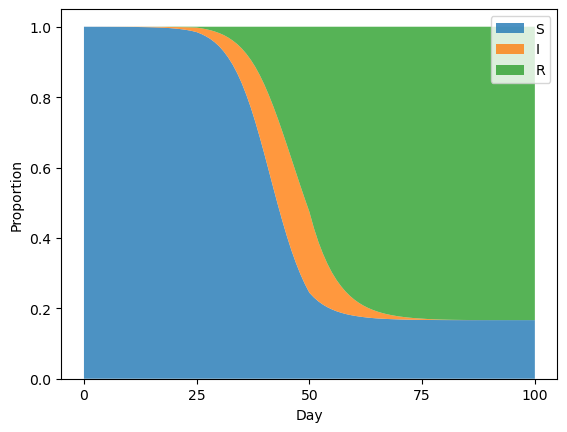

In [7]:
plot_SRI(S, I, R, d=0,sc=0)

Run Gibbs sampling:

In [9]:
run_chain   = False
sample_type = 'paper'
n_samples   = 5000
p =0.03
file_name = './../Data/scenario1_p3'

MCMC_chain1 = {}
if run_chain:
    MCMC_chain1 = gibbs_sampling(data1, samples=n_samples, burnin=5000, T_max=stop_ind1,thinning=10, delta_sample=sample_type, p=p)
    with open(f'{file_name}.pkl', 'wb') as f:
        pickle.dump(MCMC_chain1, f)
else:
    with open(f'{file_name}.pkl', 'rb') as f:
        MCMC_chain1 = pickle.load(f)

#### Results

Find $\delta$,$\beta$ and $\gamma$ estimators:

In [10]:
delta_est, beta_est, gamma_est = get_estimators(MCMC_chain1, stop_ind1, n_samples)
stage_est = np.cumsum(delta_est, dtype=int)-1

NameError: name 'get_estimators' is not defined

True change points=[ 0 25 50 75]
Predicted change points=[ 0 25 50 75 98]


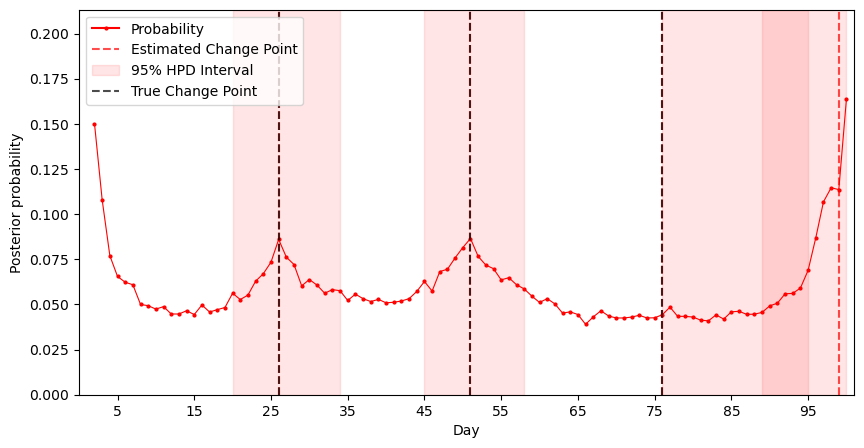

In [63]:
print(f"True change points={np.where(delta_true[:,0]==1)[0]}")
print(f"Predicted change points={np.where(delta_est==1)[0]}")

prob_delta, HPD = compute_probs(MCMC_chain1, delta_est, 0.05)

plot_delta(prob_delta, delta_true[:,0], delta_est, HPD, T_max=stop_ind1)

In [76]:
beta_mean,  beta_mode,  beta_median  = comp_stat(MCMC_chain1, 'beta', bins=20)
gamma_mean, gamma_mode, gamma_median = comp_stat(MCMC_chain1, 'gamma', bins=20)

In [71]:
stage = np.array(MCMC_chain1["Stage"])
b = np.array([[MCMC_chain1["b"][s][stage[s][t]] for t in range(T_max)] for s in range(n_samples)])
r = np.array([[MCMC_chain1["r"][s][stage[s][t]] for t in range(T_max)] for s in range(n_samples)])

(array([60.,  0.,  0.,  0., 17., 22.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([3.24292911, 3.49953743, 3.75614575, 4.01275408, 4.2693624 ,
        4.52597072, 4.78257904, 5.03918736, 5.29579569, 5.55240401,
        5.80901233, 6.06562065, 6.32222897, 6.5788373 , 6.83544562,
        7.09205394, 7.34866226, 7.60527058, 7.86187891, 8.11848723,
        8.37509555]),
 <BarContainer object of 20 artists>)

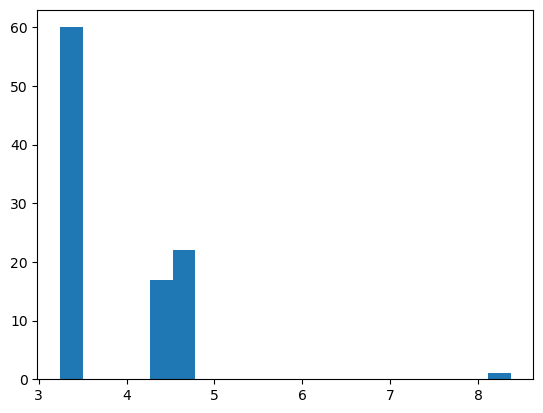

In [74]:
t = 10
plt.hist(b[t,:], bins=20)

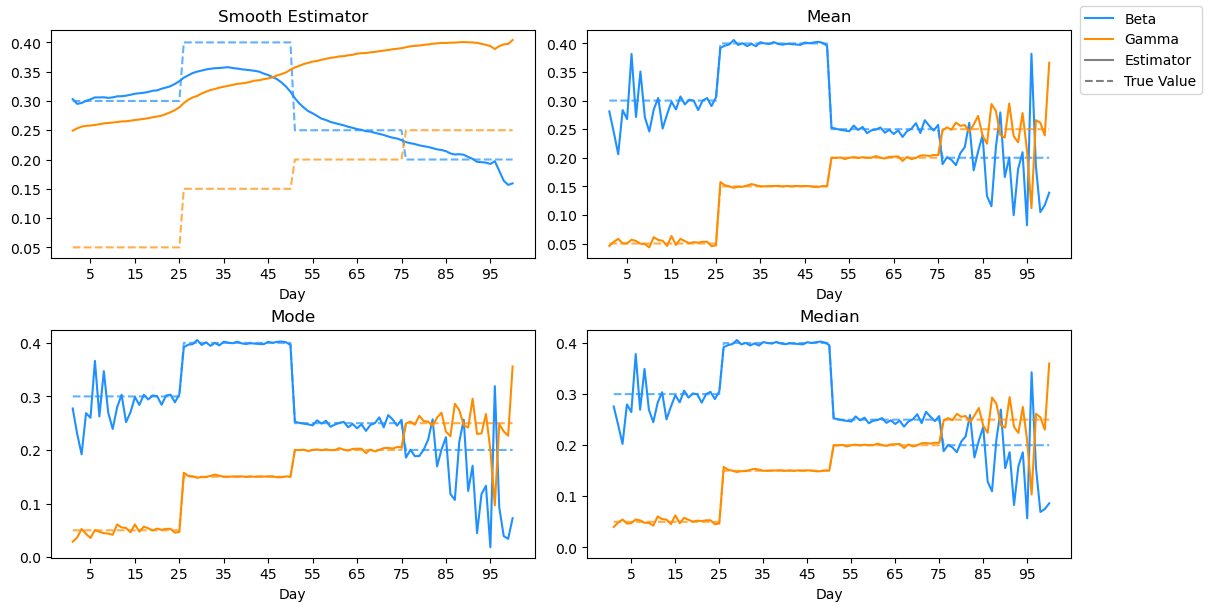

In [78]:
plot_bg(beta_true[0][:stop_ind1], beta_est, beta_mean, beta_mode, beta_median,
        gamma_true[0][:stop_ind1], gamma_est, gamma_mean, gamma_mode, gamma_median, stop_ind1)

Plot $\beta$ and $\gamma$ sample distributions:

Beta:


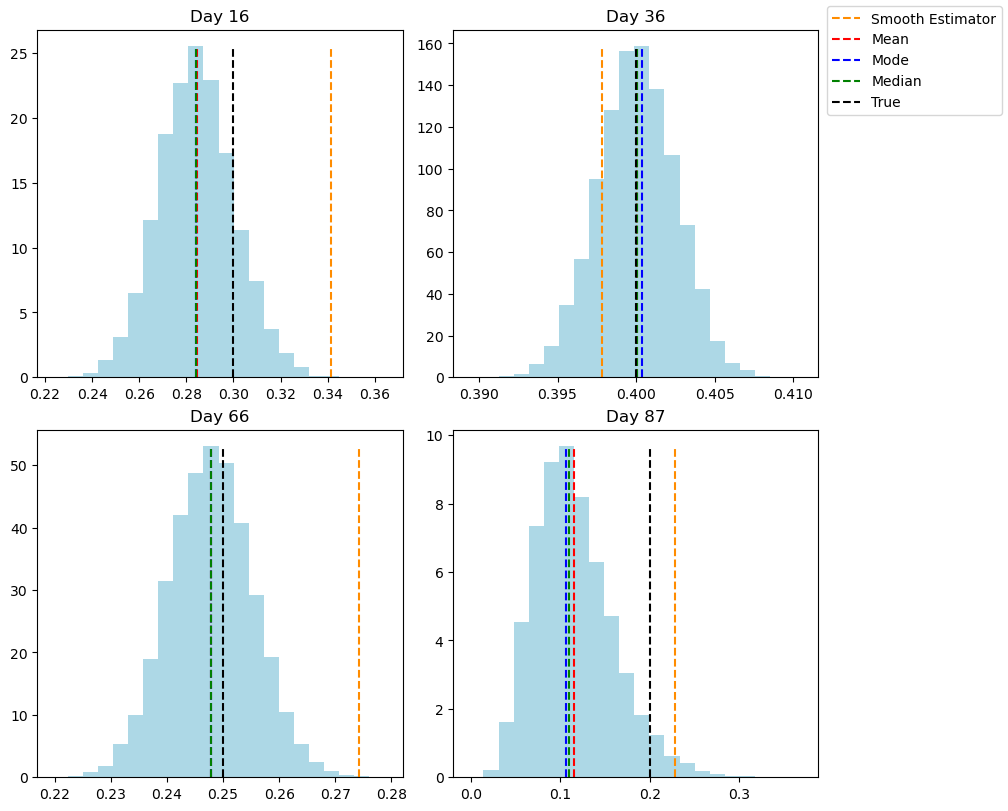

In [57]:
times=[15, 35, 65, 86]
print("Beta:")
plot_distrib(MCMC_chain1, 'beta', beta_est, beta_mean, beta_mode, beta_median, beta_true[0][:stop_ind1], 20, times)

Gamma:


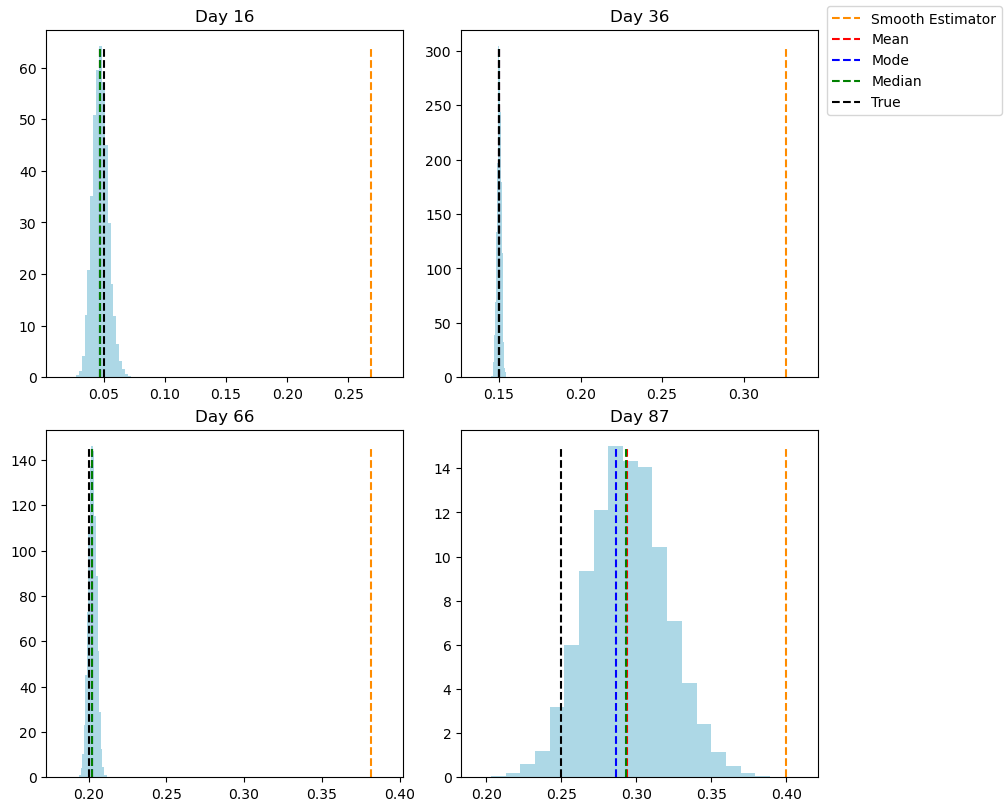

In [58]:
print("Gamma:")
plot_distrib(MCMC_chain1, 'gamma', gamma_est, gamma_mean, gamma_mode, gamma_median, gamma_true[0][:stop_ind1], 20, times)

Analyse sampling perfomance with metrics:

In [24]:
ARI = comp_ARI(stage_true[:,0], stage_est)
MI,max_ = comp_MI(stage_true[:,0], stage_est)
print(f"ARI = {round(ARI,4)} out of 1.0000\nMI = {round(MI,4)} out of {round(max_,4)}")

ARI = 0.9744 out of 1.0000
MI = 1.3863 out of 1.3863


### Scenario 2

In [25]:
data2,stop_ind2 = sanitise_data(S, I, R, Delta_I, Delta_R, sc=1, d=0)

data2

,S,I,R,PI,Delta_I,Delta_R
0,999950,50,0,0.000050,-1,-1
1,999926,69,5,0.000069,24,5
2,999903,85,12,0.000085,23,7
3,999880,94,26,0.000094,23,14
4,999844,115,41,0.000115,36,15
...,...,...,...,...,...,...
96,572216,4,427780,0.000004,1,5
97,572216,3,427781,0.000003,0,1
98,572216,2,427782,0.000002,0,1
99,572216,1,427783,0.000001,0,1


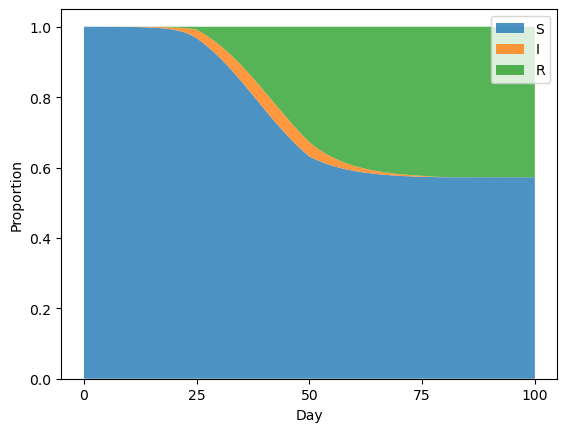

In [26]:
plot_SRI(S, I, R, d=0,sc=1)

In [27]:
run_chain   = False
sample_type = 'paper'
n_samples   = 1000
p =0.03
file_name = './../Data/scenario2_p3'

MCMC_chain2 = {}
if run_chain:
    MCMC_chain2 = gibbs_sampling(data2, samples=n_samples, burnin=5000,T_max=stop_ind2, thinning=10, delta_sample=sample_type, p=p)
    with open(f'{file_name}.pkl', 'wb') as f:
        pickle.dump(MCMC_chain2, f)
else:
    with open(f'{file_name}.pkl', 'rb') as f:
        MCMC_chain2 = pickle.load(f)

#### Results

In [28]:
delta_est, beta_est, gamma_est = get_estimators(MCMC_chain2, stop_ind2, n_samples)
stage_est = np.cumsum(delta_est, dtype=int)-1

True change points=[ 0 25 50 75]
Predicted change points=[ 0 26 45 76 96]


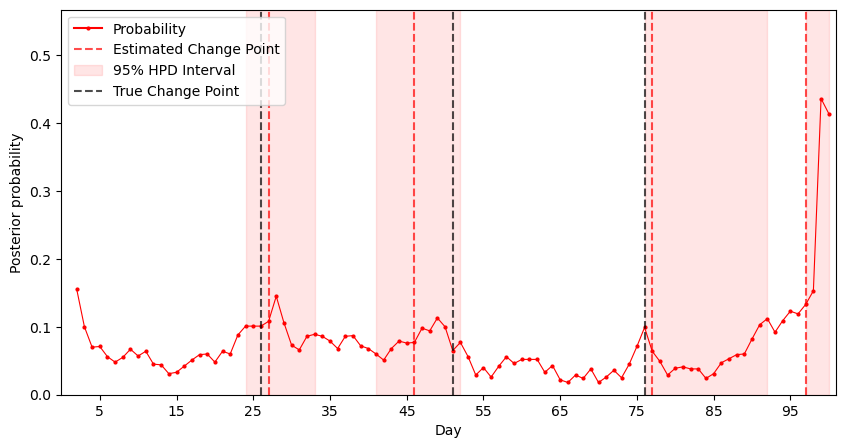

In [29]:
print(f"True change points={np.where(delta_true[:,1]==1)[0]}")
print(f"Predicted change points={np.where(delta_est==1)[0]}")

prob_delta, HPD = compute_probs(MCMC_chain2, delta_est, 0.05)

plot_delta(prob_delta, delta_true[:,1], delta_est, HPD, T_max=stop_ind2)

In [30]:
beta_mean,  beta_mode,  beta_median  = comp_stat(MCMC_chain2, 'beta', bins=20)
gamma_mean, gamma_mode, gamma_median = comp_stat(MCMC_chain2, 'gamma', bins=20)

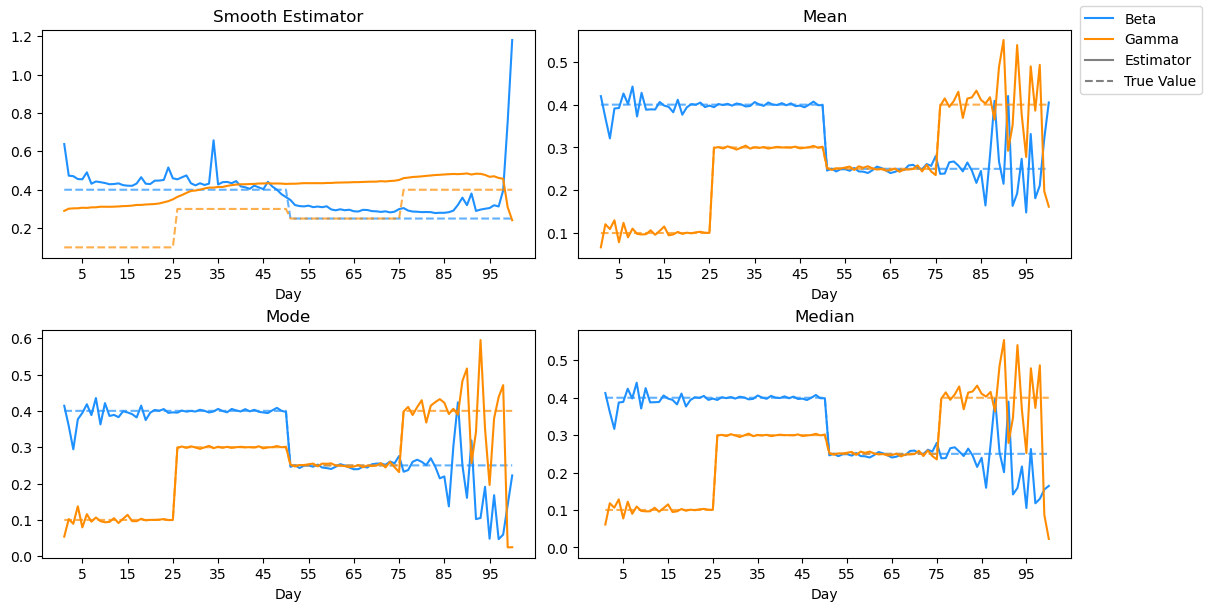

In [31]:
plot_bg(beta_true[1][:stop_ind2], beta_est, beta_mean, beta_mode, beta_median,
        gamma_true[1][:stop_ind2], gamma_est, gamma_mean, gamma_mode, gamma_median, stop_ind2)

In [32]:
ARI = comp_ARI(stage_true[:,1][:stop_ind2], stage_est,T_max=stop_ind2)
MI,max_ = comp_MI(stage_true[:,1][:stop_ind2], stage_est,T_max=stop_ind2)
print(f"ARI = {round(ARI,4)} out of 1.0000\nMI = {round(MI,4)} out of {round(max_,4)}")

ARI = 0.7756 out of 1.0000
MI = 1.1646 out of 1.3863


### Scenario 3

In [33]:
data3,stop_ind3 = sanitise_data(S, I, R, Delta_I, Delta_R, sc=2, d=0)

data3

,S,I,R,PI,Delta_I,Delta_R
0,999950,50,0,0.000050,-1,-1
1,999940,53,7,0.000053,10,7
2,999924,62,14,0.000062,16,7
3,999911,71,18,0.000071,13,4
4,999895,80,25,0.000080,16,7
...,...,...,...,...,...,...
96,159,3,999838,0.000003,0,1
97,159,2,999839,0.000002,0,1
98,159,1,999840,0.000001,0,1
99,159,1,999840,0.000001,0,0


In [34]:
stop_ind3 = 98

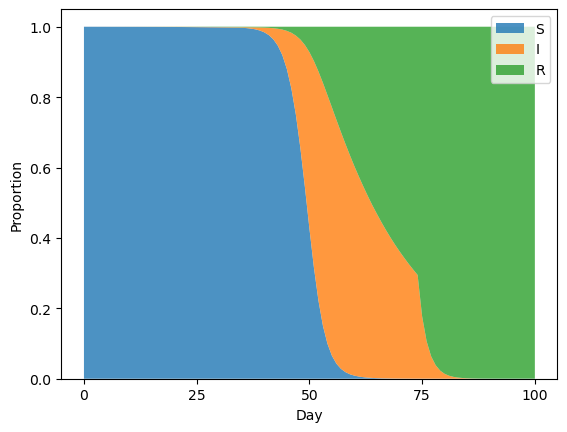

In [35]:
plot_SRI(S, I, R, d=0,sc=2)

In [36]:
run_chain   = False
sample_type = 'paper'
n_samples   = 5000
p =0.001
file_name = './../Data/scenario3_p01'

MCMC_chain3 = {}
if run_chain:
    MCMC_chain3 = gibbs_sampling(data3, samples=n_samples, burnin=5000, thinning=10, T_max=stop_ind3,delta_sample=sample_type, p=p)
    with open(f'{file_name}.pkl', 'wb') as f:
        pickle.dump(MCMC_chain3, f)
else:
    with open(f'{file_name}.pkl', 'rb') as f:
        MCMC_chain3 = pickle.load(f)

#### Results

In [37]:
delta_est, beta_est, gamma_est = get_estimators(MCMC_chain3, stop_ind3, n_samples)
stage_est = np.cumsum(delta_est, dtype=int)-1

True change points=[ 0 35 74]
Predicted change points=[ 0 35 74]


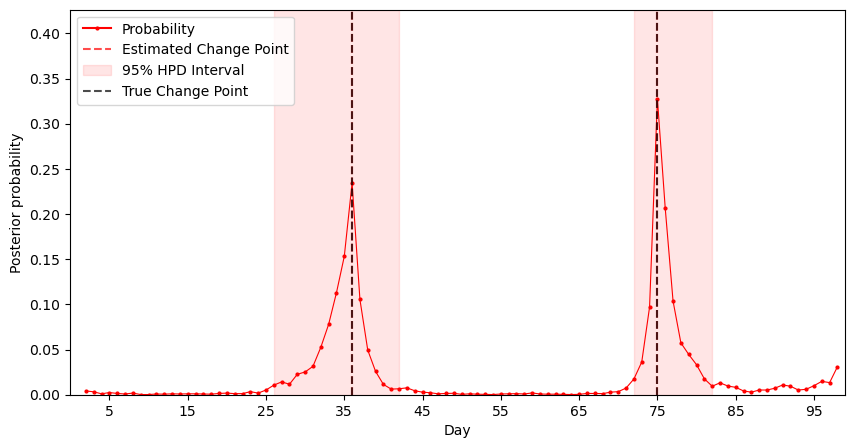

In [38]:
print(f"True change points={np.where(delta_true[:,2]==1)[0]}")
print(f"Predicted change points={np.where(delta_est==1)[0]}")

prob_delta, HPD = compute_probs(MCMC_chain3, delta_est, 0.05)

plot_delta(prob_delta, delta_true[:,2], delta_est, HPD, T_max=stop_ind3)

In [39]:
beta_mean,  beta_mode,  beta_median  = comp_stat(MCMC_chain3, 'beta', bins=20)
gamma_mean, gamma_mode, gamma_median = comp_stat(MCMC_chain3, 'gamma', bins=20)

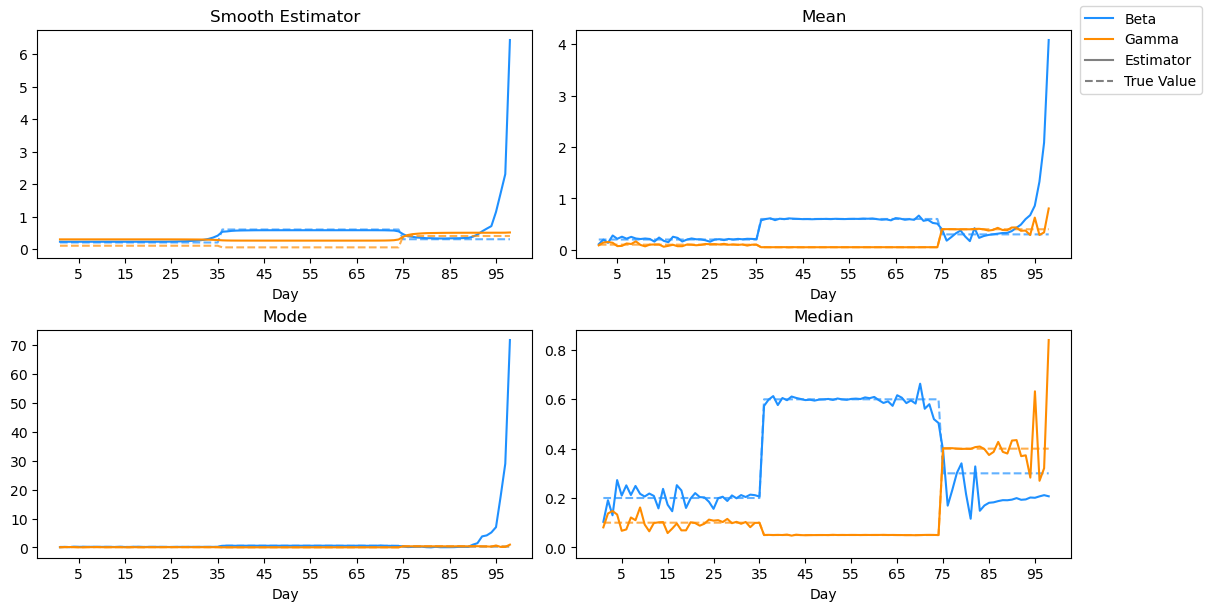

In [40]:
plot_bg(beta_true[2][:stop_ind3], beta_est, beta_mean, beta_mode, beta_median,
        gamma_true[2][:stop_ind3], gamma_est, gamma_mean, gamma_mode, gamma_median, stop_ind3)

In [41]:
ARI = comp_ARI(stage_true[:,2][:stop_ind3], stage_est,T_max=stop_ind3)
MI,max_ = comp_MI(stage_true[:,2][:stop_ind3], stage_est,T_max=stop_ind3)
print(f"ARI = {round(ARI,4)} out of 1.0000\nMI = {round(MI,4)} out of {round(max_,4)}")

ARI = 1.0 out of 1.0000
MI = 1.079 out of 1.079


### Sensitivity Analysis

In [42]:
with open('./../Data/scenario3_p01.pkl', 'rb') as f:
    MCMC_chain3_1 = pickle.load(f)
with open('./../Data/scenario3_p2.pkl', 'rb') as f:
    MCMC_chain3_2 = pickle.load(f)
with open('./../Data/scenario3_p5.pkl', 'rb') as f:
    MCMC_chain3_3 = pickle.load(f)

ps = [0.001, 0.02, 0.05]
chains = [MCMC_chain3_1, MCMC_chain3_2, MCMC_chain3_3]
stops = [98,99,98]

Prior parameter: p = 0.001

True change points=[ 0 35 74]
Predicted change points=[ 0 35 74]
ARI = 1.0 out of 1.0000
MI = 1.079 out of 1.079


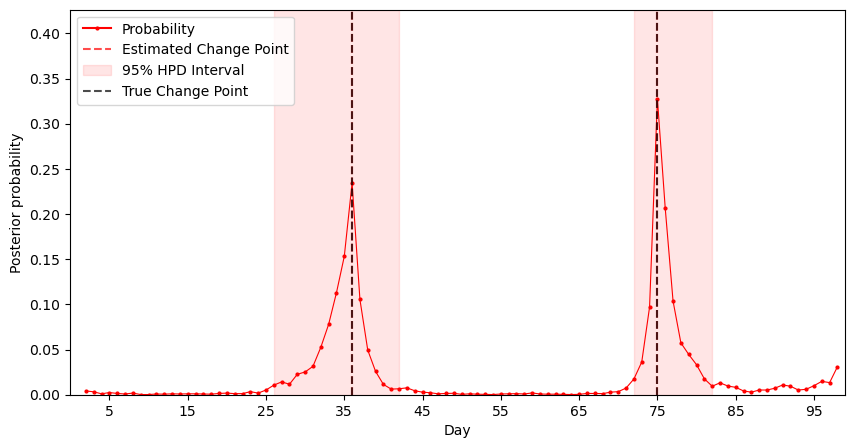

In [43]:
def process_chain(chain, p, stop):
    delta_est, beta_est, gamma_est = get_estimators(chain, stop, n_samples)
    stage_est = np.cumsum(delta_est, dtype=int)-1
    
    print(f"Predicted change points={np.where(delta_est==1)[0]}")
    
    prob_delta, HPD = compute_probs(chain, delta_est, 0.05)
    plot_delta(prob_delta, delta_true[:,2], delta_est, HPD, T_max=stop)

    ARI      = comp_ARI(stage_true[:,2][:stop], stage_est, T_max=stop)
    MI, max_ = comp_MI(stage_true[:,2][:stop],  stage_est, T_max=stop)
    print(f"ARI = {round(ARI,4)} out of 1.0000\nMI = {round(MI,4)} out of {round(max_,4)}")

print(f"Prior parameter: p = {ps[0]}\n")
print(f"True change points={np.where(delta_true[:,2]==1)[0]}")
process_chain(chains[0], ps[0], stops[0])

Prior parameter: p = 0.02

True change points=[ 0 35 74]
Predicted change points=[ 0 34 36 74 75 90 96]
ARI = 0.8803 out of 1.0000
MI = 1.0681 out of 1.0821


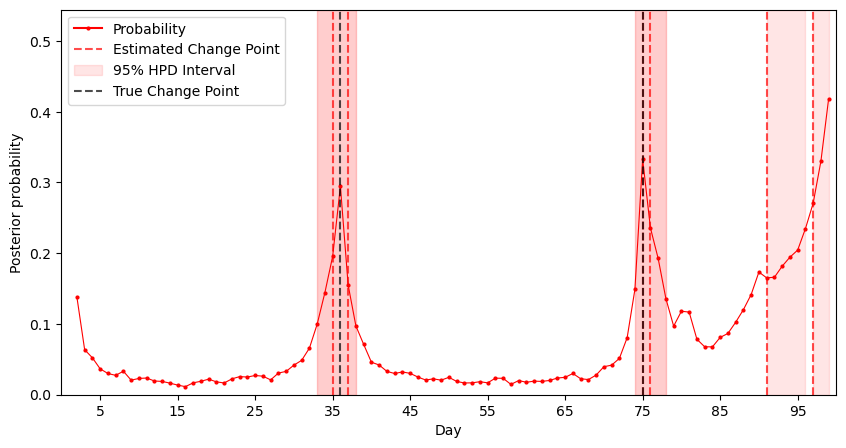

In [44]:
print(f"Prior parameter: p = {ps[1]}\n")
print(f"True change points={np.where(delta_true[:,2]==1)[0]}")
process_chain(chains[1], ps[1], stops[1])

Prior parameter: p = 0.05

True change points=[ 0 35 74]
Predicted change points=[ 0 11 30 35 45 60 71 74 76 81 87 90 93 96]
ARI = 0.3592 out of 1.0000
MI = 1.079 out of 1.079


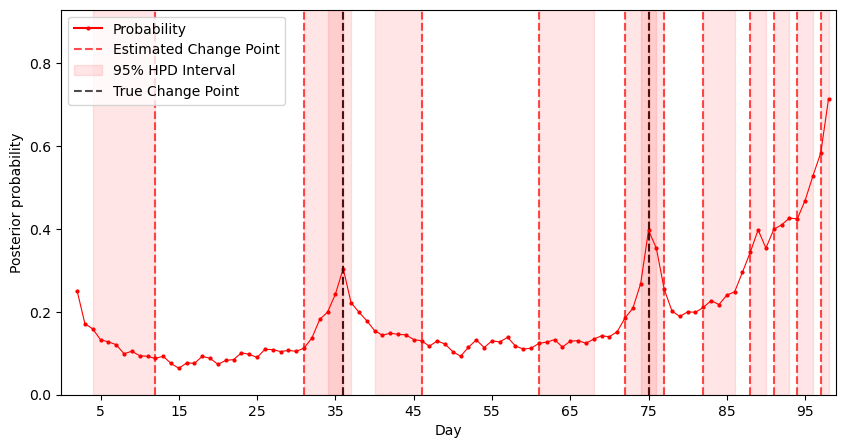

In [45]:
print(f"Prior parameter: p = {ps[2]}\n")
print(f"True change points={np.where(delta_true[:,2]==1)[0]}")
process_chain(chains[2], ps[2], stops[2])